In [1]:
# Example: Custom Layout Pass with NetworkX for VQE or GHZ optimization

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, Layout, PassManager, TransformationPass
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.passes import SetLayout,VF2Layout
import qiskit_ibm_runtime.fake_provider as fk  # Example IBM device
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_circuit_layout, plot_coupling_map

In [2]:
import networkx as nx
from qiskit.transpiler import Layout, CouplingMap


def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Find exact cycle of length n, else nearest larger cycle.
    """
    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())
    cycles = list(nx.cycle_basis(G))

    exact = [c for c in cycles if len(c) == n]
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):
    """
    Adaptive layout for ring circuits with ancilla if needed.
    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits

    #layout_dict = {i: cycle[i] for i in range(required_qubits)}
    #layout = Layout(layout_dict)

    return required_qubits, ancilla#, layout



In [3]:
n=14
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, Total needed: {required_qubits}, Ancilla: {ancilla_count}")

qc= RealAmplitudes(num_qubits=required_qubits,reps=1\
                   ,entanglement='circular',flatten=True)

#obtain cycle-graph with circuit+ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

layout_dict = {qc.qubits[i]: cycle[i] for i in range(required_qubits)}
layout = Layout(layout_dict)



Logical qubits: 14, Total needed: 20, Ancilla: 6


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13423/3668825620.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc= RealAmplitudes(num_qubits=required_qubits,reps=1\


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13423/3929494150.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


depth 28
CNOT count 20


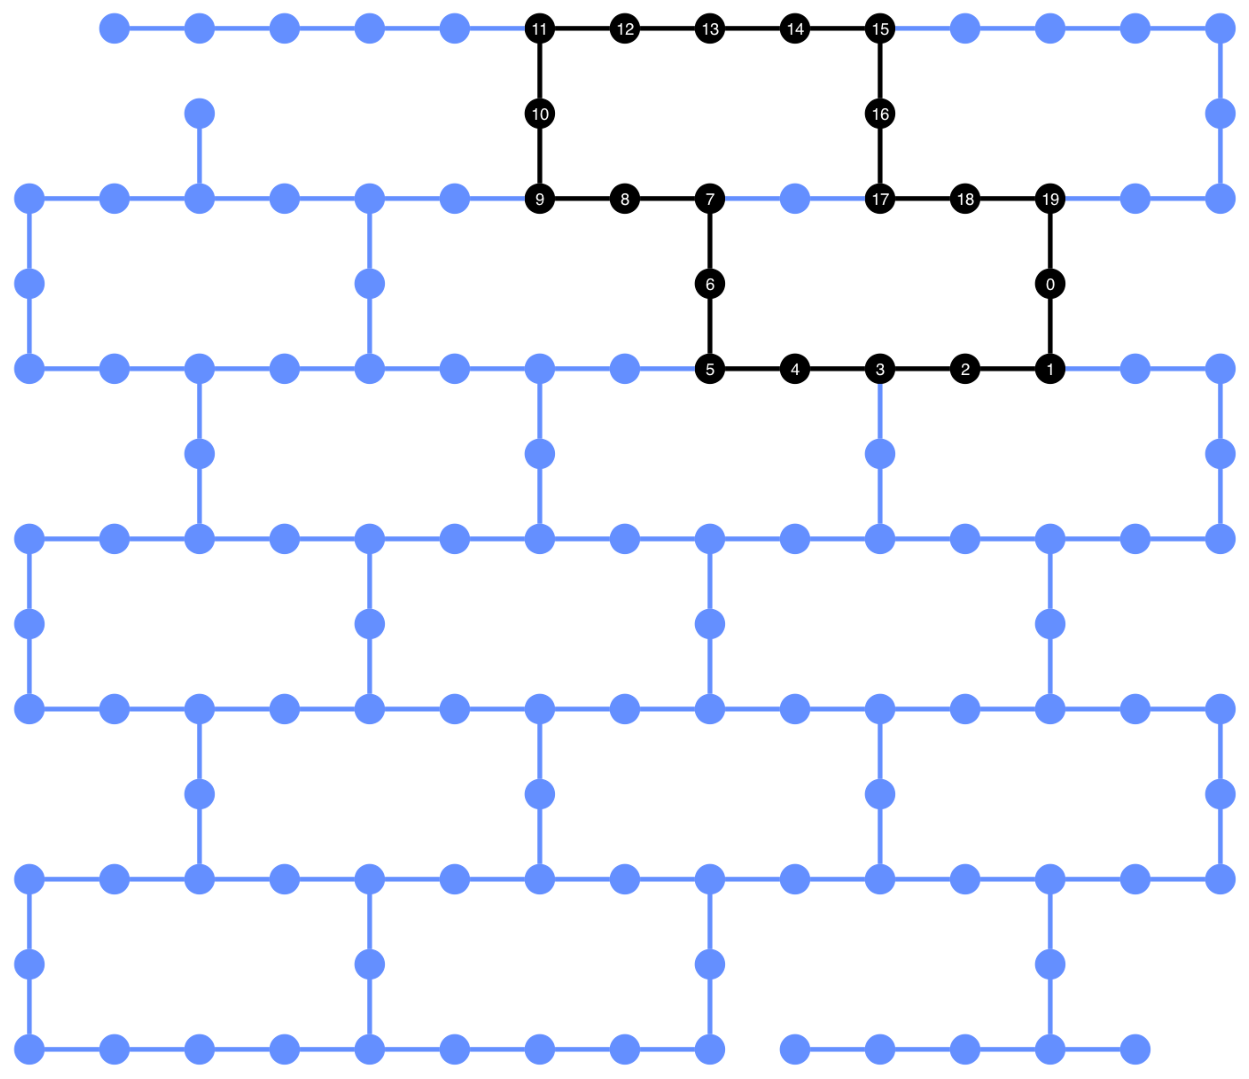

In [4]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout,
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc)

print("depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)